In [5]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
from nltk.text import Text
import os
import multiprocessing

import gensim
from gensim.test.utils import datapath
import tikzplotlib

## Make positive and negative vectors

In [6]:
%%time
#load cornetto & liwc
cornetto = pd.read_csv('emotion_cornetto.csv')
corn_pos=cornetto.loc[(cornetto['polarity'] > 0.4) & (cornetto['confidence'] > 0.8)]['word']
corn_neg = cornetto.loc[(cornetto['polarity'] < -0.4) & (cornetto['confidence'] > 0.8)]['word']
len(corn_pos),len(corn_neg)

CPU times: user 13.2 ms, sys: 5.39 ms, total: 18.5 ms
Wall time: 18.4 ms


(354, 305)

## Load W2V models

In [7]:
%%time
#kopieercode voor laden
model_40s = Word2Vec.load("models_2107/model_40_2607.wordvectors", mmap='r')
model_50s = Word2Vec.load("models_2107/model_50_2607.wordvectors", mmap='r')
model_60s = Word2Vec.load("models_2107/model_60_2607.wordvectors", mmap='r')
model_70s = Word2Vec.load("models_2107/model_70_2607.wordvectors", mmap='r')
model_80s = Word2Vec.load("models_2107/model_80_2607.wordvectors", mmap='r')
model_90s = Word2Vec.load("models_2107/model_90_2607.wordvectors", mmap='r')

na_model_40s = Word2Vec.load("models_2107/na_model_40_2607.wordvectors", mmap='r')
na_model_50s = Word2Vec.load("models_2107/na_model_50_2607.wordvectors", mmap='r')
na_model_60s = Word2Vec.load("models_2107/na_model_60_2607.wordvectors", mmap='r')
na_model_70s = Word2Vec.load("models_2107/na_model_70_2607.wordvectors", mmap='r')
na_model_80s = Word2Vec.load("models_2107/na_model_80_2607.wordvectors", mmap='r')
na_model_90s = Word2Vec.load("models_2107/na_model_90_2607.wordvectors", mmap='r')

# model_nrc = Word2Vec.load("models/model_nrc_1407.wordvectors", mmap='r')
# model_tel = Word2Vec.load("models/model_tel_1407.wordvectors", mmap='r')
# model_vk = Word2Vec.load("models/model_vk_1407.wordvectors", mmap='r')
# model_trouw = Word2Vec.load("models/model_trouw_1407.wordvectors", mmap='r')
models_dec = [model_40s,model_50s,model_60s,model_70s,model_80s,model_90s]
models_na = [na_model_40s,na_model_50s,na_model_60s,na_model_70s,na_model_80s,na_model_90s]
models = models_dec + models_na

CPU times: user 4.66 s, sys: 706 ms, total: 5.37 s
Wall time: 5.54 s


In [8]:
#get vocab sizes
for i in models_dec:
    print((len(i.wv.vocab)))
    
for i in models_na:
    print((len(i.wv.vocab)))

9295
28294
40969
68516
123315
113668
7774
25650
35506
55468
79635
70929


In [9]:
#load liwc
pos = ['Posemo','Optim','Posfeel','Achieve']
neg = ['Swear','Sad','Anger','Negemo']
liwc = pd.read_csv('LIWC_Dutch.csv')
liwc_pos = sum([list(liwc[i]) for i in pos],[])
liwc_neg=sum([list(liwc[i]) for i in neg],[])

In [10]:
#combine
all_pos = liwc_pos + list(corn_pos)
all_neg = liwc_neg + list(corn_neg)
len(all_pos), len(all_neg)

(1370, 1321)

## Calculate association score

In [18]:
#synsets
syns_homo = ['homoseksuele', 'gay', 'flikker', 'homo', 'homofiel', 'homoseksueel']
syns_neger = ['moor', 'neger', 'negerin'] 
syns_zigeuner = ['roma', 'zigeunerin', 'gipsy', 'zigeuner']


In [14]:
def calc_distance_between_vectors(vec1, vec2, distype = 'norm'):
    return np.linalg.norm(np.subtract(vec1, vec2))

In [15]:
def ass_score_over_time(models,features,pos,neg):
    means = []
    bounds = []
    values = []
    year = []
    for index, model in enumerate(models):       
        v1 = np.mean([model[word] for word in pos if word in model.wv.vocab], axis=0)
        #v = calculate_vectors(model, male_words, female_words)
        v2 = np.mean([model[word] for word in neg if word in model.wv.vocab], axis=0)
        x = []
        y = []
        for word in features:
            try:
                x.append(calc_distance_between_vectors(v1, model[word]))
                y.append(calc_distance_between_vectors(v2, model[word]))
            except:
                x.append(0)
                y.append(0)
        C = [x_ - y_ for x_, y_ in zip(x, y)]
        values.append(C)
        means.append(np.mean(C))
        values_t = list(map(list, zip(*values)))
        #bounds.append(bootstrap(C, np.mean, confidence_level=0.95, n_resamples=1000).confidence_interval)
    return features,values_t

<ipython-input-15-7f2d52f3407f>:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  v1 = np.mean([model[word] for word in pos if word in model.wv.vocab], axis=0)
<ipython-input-15-7f2d52f3407f>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  v2 = np.mean([model[word] for word in neg if word in model.wv.vocab], axis=0)
<ipython-input-15-7f2d52f3407f>:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  x.append(calc_distance_between_vectors(v1, model[word]))
<ipython-input-15-7f2d52f3407f>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  y.append(calc_distance_between_vectors(v2, model[word]))


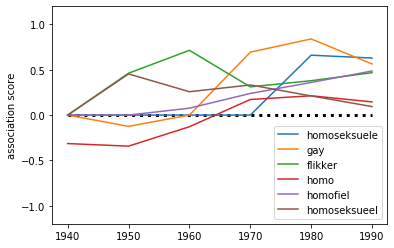

CPU times: user 438 ms, sys: 20.5 ms, total: 459 ms
Wall time: 499 ms


In [19]:
%%time
features,values = ass_score_over_time(models_na,syns_homo,all_pos,all_neg)
x = [1940,1950,1960,1970,1980,1990]
fig, ax = plt.subplots()
for i in range(len(features)):
    ax.plot(x, values[i], label = features[i])
ax.hlines(y=0, xmin=1940, xmax=1990, linewidth=3,linestyles='dotted')
plt.legend()
plt.ylim(-1.2,1.2)
plt.ylabel('association score')
plt.show()
#fig.savefig("na_asso_zigeuner_2607.pdf")

In [ ]:
%%time
features,values = ass_score_over_time(models_dec,syns_zigeuner,all_pos,all_neg)
x = [1940,1950,1960,1970,1980,1990]
for i in range(len(features)):
    plt.plot(x, values[i], label = features[i])
plt.legend()
plt.show()
print(values)